# Assignment

## Task 1

#### Mathematical motivation

A matrix $A$'s, transformation can be represented by eigenvalues $\lambda_i$, the scale of its distortion, and their corresponding eigenvectors $|\psi_i\rangle$, the orientation of that distortion. 
$$
A|\psi\rangle = \lambda_i|\psi_i\rangle
$$
Finding the minimum eigenvalue $\lambda_{min}$ of a matrix is useful in many problems, such as in chemistry where the Hamiltonians, or energy dynamics, of a system can be represented by matrices and the minimum eigenvalue represents the ground state (minimum energy) $\lambda_{gs}$ of the system.

These Hamiltonians $H$ are real energy observables where 
$$
|\psi_t\rangle = U(t)|\psi_0\rangle 
$$
and $U(t)=e^{-itH}$ is a matrix exponential with some important properties
1. $H$ has real eigenvalues justifying its use to represent the Hamiltonian observables ${^1}$
2. $U$ is unitary with phases $e^{i\theta}$ as eigenvalues ${^2}$
3. The expected value (or probability) of the Hamiltonian $H$ on a state $|\psi\rangle$ is given by $\langle H\rangle_{\psi}=\langle\psi|H|\psi\rangle$ ${^3}$

#### Approaches to finding the minimum eigenvalue

One approach is to calculate the $e^{i\theta}$ eigenvalue directly with Quantum Phase Estimation (QPE) which involves using phase kickback to write the phase of $U$ in the Fourier basis and taking the inverse of the Quantum Fourier Transform (QFT) to get back something measurable. However, this requires circuit depths exceeding the hardware available in the Noisy intermediate-scale quantum (NISQ) era.

Another alternative is to use Variational Quantum Eigensolvers (VQE) where we select an initial state (or ansatz) $|\psi\rangle$ to minimize the expected value of the Hamiltonian $\langle H\rangle_\psi$, giving us an upper bound on the minimum eigenvalue $\lambda_{min}$. To choose the ansatz some approaches such as Unitary Coupled Cluster (UCC) explore only a subspace of possible states, exploiting domain-specific quantum chemistry knowledge. However the problem, with these approaches is they they can be hard to compile and optimize for current quantum computers.

The approach explored in the paper is to use VQE but with an ansatz chosen to explore the whole space of states (negating the need for chemistry knowledge) and optimized to be run on quantum hardware.

#### Implementation steps
1. Choose ansatz e.g. Hartree Fock State or vacuum state $|0\rangle$
2. Choose variational form UCCSD
3. Choose parameter optimization e.g. gradient descent, SPSA, COBYLA

#### Mathematical Appendix

1. $H$ Hamiltonian is hermitian which means that it is equal to its conjugate transpose $H=H^\dagger$. By the spectral theorem $H$ has real eigenvalues justifying its use to represent the Hamiltonian observables.
2. $U$ is unitary which means that its inverse is equal to its conjugate transpose $U^{-1}=U^\dagger$. We prove this using the fact that $H$ is hermitian so that $U^\dagger U = (e^{-itH})^{\dagger} e^{-itH}= e^{itH^\dagger}e^{-itH}=e^{itH}e^{-itH} = I$. Furthermore, the matrix exponential $U$ of $H$ is still a matrix by expansion of exponential as Taylor series but with the property that $U|\psi\rangle = e^{i\theta}|\psi\rangle$ i.e. unitary matrices have phases $e^{i\theta}$ as eigenvalues
3. The expected value then provides an upper bound for the minimum eigenvalue $\lambda_{min}\leq \langle H\rangle_\psi=\langle\psi|H|\psi\rangle$ because $H$ can be written as the weighted sum of its eigenvectors $H = \sum_{i=1}^n \lambda_i|\psi_i\rangle\langle\psi_i|$ which when substituting in gives $\langle H\rangle_\psi = \sum_{i=1}^n \lambda_i|\langle\psi_i|\psi\rangle|^2$ where $|\langle\psi_i|\psi\rangle|^2\geq 0$ giving an upper bound 

## Task 2

##### Imports

In [3]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from typing import Optional, List

##### Utility functions

In [4]:
# copied from lecture slides
def make_params(fst: int, snd: Optional[int] = None, label: str = "θ") -> List[Parameter]:
    start = 0 if snd is None else fst
    end = fst if snd is None else snd
    assert end >= start
    return [Parameter(f"{label}[{idx}]") for idx in range(start, end)]

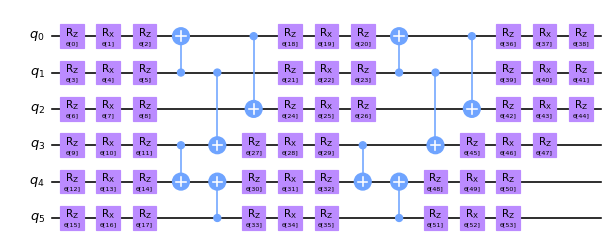

In [16]:
def hardware_efficient_ansatz(depth):
    num_qubits = 6
    num_gates_per_euler_rot = 3
    he_ansatz_num_params = num_qubits * num_gates_per_euler_rot * (depth + 1) 
    he_ansatz_params = make_params(he_ansatz_num_params)
    he_ansatz = QuantumCircuit(num_qubits)
    for q in range(num_qubits):
        params_start = q * num_gates_per_euler_rot
        params_stop = params_start + num_gates_per_euler_rot
        euler_rotation(he_ansatz, q, he_ansatz_params[params_start: params_stop])
    for d in range(depth):
        entangler(he_ansatz)
        for q in range(num_qubits):
            params_start = num_gates_per_euler_rot * ((d + 1) * num_qubits + q)
            params_stop = params_start + num_gates_per_euler_rot
            euler_rotation(he_ansatz, q, he_ansatz_params[params_start: params_stop])
    return he_ansatz

def euler_rotation(quantum_circuit, qubit, params):
    quantum_circuit.rz(params[0], qubit)
    quantum_circuit.rx(params[1], qubit)
    quantum_circuit.rz(params[2], qubit)

def entangler(quantum_circuit):
    quantum_circuit.cx([1, 3, 1, 0, 5], [0, 4, 3, 2, 4])

hardware_efficient_ansatz(2).draw("mpl", scale=0.8)



## Task 3